In [1]:
state = 'AR'    # 2-letter state code
k = 4           # number of districts

In [2]:
# Read county graph from the json file "<state>_county.json"
filepath = 'C:\\districting-data-2020\\'
filename = state + '_county.json'

# GerryChain has a built-in function for reading graphs of this type:
from gerrychain import Graph
G = Graph.from_json( filepath + filename )

for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [3]:
# Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

import math
L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 749117 and U = 756645 and k = 4


In [4]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

import networkx as nx
DG = nx.DiGraph(G)   # directed version of G

# create variables
# x[i,j] equals one when county i is assigned to district j
x = m.addVars(G.nodes, k, vtype=GRB.BINARY)  

# y[u,v,j] equals one when arc (u,v) is cut because u->j but not v->j
y = m.addVars(DG.edges, k, vtype=GRB.BINARY) 

# z[j] is inverse Polsby-Popper score for district j
z = m.addVars(k)

# A[j] = area of district j
A = m.addVars(k)

# P[j] = perimeter of district j
P = m.addVars(k)

for j in range(k):
    z[j].lb = 0
    A[j].lb = 0
    P[j].lb = 0

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01


In [5]:
# objective is to minimize sum of inverse Polsby-Popper scores
coef = 1 / ( 2 * math.pi )
m.setObjective( coef * gp.quicksum( z[j] for j in range(k) ), GRB.MINIMIZE )

In [6]:
# add SOCP constraints relating inverse Polsby-Popper score z[j] to area and perimeter
m.addConstrs( P[j] * P[j] <= 2 * A[j] * z[j] for j in range(k) )

# add constraints on areas A[j] 
m.addConstrs( A[j] == gp.quicksum( G.nodes[i]['area'] * x[i,j] for i in G.nodes ) for j in range(k) )

# add constraints on perimeters P[j]
for j in range(k):
    m.addConstr( P[j] == gp.quicksum( DG.edges[u,v]['shared_perim'] * y[u,v,j] for u,v in DG.edges )
             + gp.quicksum( G.nodes[i]['boundary_perim'] * x[i,j] for i in G.nodes if G.nodes[i]['boundary_node'] ) )
    
m.update()

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k)) == 1 for i in G.nodes )

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v,j] for u,v in DG.edges for j in range(k) )

m.update()

In [8]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY)

# To solve the MIP faster, fix a district root:
r[0,0].LB = 1

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

f = m.addVars( DG.edges )

In [9]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[u,v] + f[v,u] <= M * ( 1 - gp.quicksum( y[u,v,j] for j in range(k) ) ) for u,v in DG.edges )

m.update()

In [10]:
# solve IP model
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2390 rows, 2532 columns and 11740 nonzeros
Model fingerprint: 0xfdc554e6
Model has 4 quadratic constraints
Variable types: 396 continuous, 2136 integer (2136 binary)
Coefficient statistics:
  Matrix range     [2e-03, 4e+05]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [2e-01, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 100 rows and 82 columns
Presolve time: 0.02s
Presolved: 2290 rows, 2450 columns, 11332 nonzeros
Presolved model has 4 quadratic constraint(s)
Variable types: 396 continuous, 2054 integer (2054 binary)

Root relaxation: objective 4.105652e-03, 1080 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00411    

 62425 19550   13.67653   28  474   14.54469   10.23554  29.6%   182  434s
 63186 19734   11.17421   26  428   14.54469   10.26044  29.5%   182  443s
 63848 19857   11.31903   25  462   14.54469   10.28637  29.3%   183  453s
 64458 20106   12.93894   27  404   14.54469   10.30475  29.2%   184  462s
 65138 20288   12.06111   29  464   14.54469   10.34390  28.9%   185  472s
 65744 20511   11.90883   28  334   14.54469   10.37281  28.7%   186  483s
 66448 20701   11.90897   31  299   14.54469   10.39993  28.5%   187  494s
 67078 20864   14.45621   35  431   14.54469   10.42495  28.3%   188  504s
 67720 21048   14.38248   36  339   14.54469   10.44686  28.2%   189  516s
 68300 21234   13.64480   33  280   14.54469   10.46781  28.0%   190  528s
 68971 21378   12.35377   25  320   14.54469   10.48169  27.9%   191  539s
 69527 21498   13.57704   31  423   14.54469   10.49895  27.8%   192  549s
 70111 21652     cutoff   25        14.54469   10.50704  27.8%   193  560s
 70751 21808   13.45681  

 136605 12168   12.96708   36  427   13.27059   12.21189  7.98%   284 2455s
 137408 11959   12.88094   34  204   13.27059   12.23037  7.84%   285 2479s
 138218 11762   12.87992   30  425   13.27059   12.25126  7.68%   285 2503s
 139129 11591     cutoff   29        13.27059   12.27186  7.53%   286 2527s
 140004 11390     cutoff   35        13.27059   12.29278  7.37%   286 2549s
 140871 11162   12.95688   35  207   13.27059   12.31335  7.21%   286 2572s
 141626 10905     cutoff   31        13.27059   12.33390  7.06%   287 2595s
 142461 10628     cutoff   31        13.27059   12.36059  6.86%   287 2619s
 143215 10373   12.62735   34  342   13.27059   12.38396  6.68%   288 2644s
 144037 10112   12.89336   25  446   13.27059   12.40315  6.54%   288 2668s
 144887  9799 infeasible   43        13.27059   12.43063  6.33%   289 2692s
 145744  9520 infeasible   32        13.27059   12.45768  6.13%   289 2717s
 146599  9166     cutoff   45        13.27059   12.48051  5.95%   289 2740s
 147473  879

In [11]:
print("The objective value is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The objective value is 13.270587263474958
District 0 has population 751754 and contains counties ['Franklin', 'Crawford', 'Benton', 'Madison', 'Sebastian', 'Washington']

District 1 has population 750788 and contains counties ['Faulkner', 'Conway', 'Pulaski', 'Saline', 'Lonoke', 'Perry']

District 2 has population 754547 and contains counties ['Little River', 'Ashley', 'Desha', 'Montgomery', 'Howard', 'Nevada', 'Grant', 'Dallas', 'Cleveland', 'Lafayette', 'Chicot', 'Pope', 'Bradley', 'Drew', 'Pike', 'Union', 'Hempstead', 'Polk', 'Clark', 'Logan', 'Miller', 'Arkansas', 'Johnson', 'Garland', 'Sevier', 'Jefferson', 'Lincoln', 'Scott', 'Hot Spring', 'Columbia', 'Ouachita', 'Yell', 'Calhoun', 'Phillips']

District 3 has population 754435 and contains counties ['Jackson', 'Clay', 'Baxter', 'Boone', 'St. Francis', 'Sharp', 'Greene', 'Woodruff', 'White', 'Lee', 'Crittenden', 'Marion', 'Prairie', 'Lawrence', 'Poinsett', 'Stone', 'Independence', 'Fulton', 'Carroll', 'Van Buren', 'Searcy', 'Rando

In [12]:
# Let's draw it on a map
import geopandas as gpd

In [13]:
# Read county shapefile from "<state>_county.shp"
filename = state + '_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

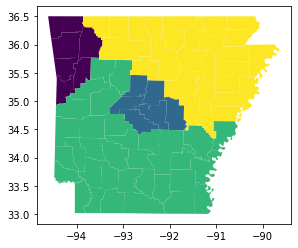

In [14]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()